# Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not  
[Kaggle Competetion]('https://www.kaggle.com/c/nlp-getting-started')

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

### Read Data

In [3]:
train_set = pd.read_csv('kaggle-NLP-train.csv')
test_set = pd.read_csv('kaggle-NLP-test.csv')

In [4]:
train_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_set.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
train_set.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Using regular expressions to clean the data.

In [7]:
import nltk
import string
from nltk.corpus import stopwords

def text_process(df, text):
    df[text] = df[text].str.replace(r"http\S+", "")
    df[text] = df[text].str.replace(r"http", "")
    df[text] = df[text].str.replace(r"@\S+", "")
    df[text] = df[text].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text] = df[text].str.replace(r"@", "at")
    df[text] = df[text].str.lower()
    return df

In [8]:
def text_process2(mess):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of clean text words
    """
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [9]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence:%.3f'%calc_prevalence(train_set['target'].values))

Prevalence:0.430


In [8]:
train_set = text_process(train_set, 'text')
test_set = text_process(test_set, 'text')

In [9]:
train_set['text'] = train_set['text'].apply(text_process2)
test_set['text'] = test_set['text'].apply(text_process2)

In [10]:
train_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [11]:
test_set.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


### Exploratory Data Analysis and Overview

In [12]:
train_set.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

In [13]:
train_set.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


Tokenization of the text column

In [14]:
from nltk.tokenize import RegexpTokenizer

In [15]:
train_set['tokens'] = train_set['text'].apply(RegexpTokenizer(r'\w+').tokenize)

### Vectorization
Now lets convert each text, represented as a list of tokens (lemmas) above, into a vector

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [17]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_set["text"].tolist()
list_targets = train_set["target"].tolist()

In [64]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print(x), 
        
unique(list_targets)

1
0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_targets, test_size=0.3,random_state=101)

In [19]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [20]:
test_set_count = count_vectorizer.transform(test_set["text"].tolist())

### Visualizing the embeddings  
so this is a dimension reduction technique that takes the bag of   
words vectors and projects them down to a 2D plane since the bag  
of words contains a lot of zeros so you're able to plot it using PVC

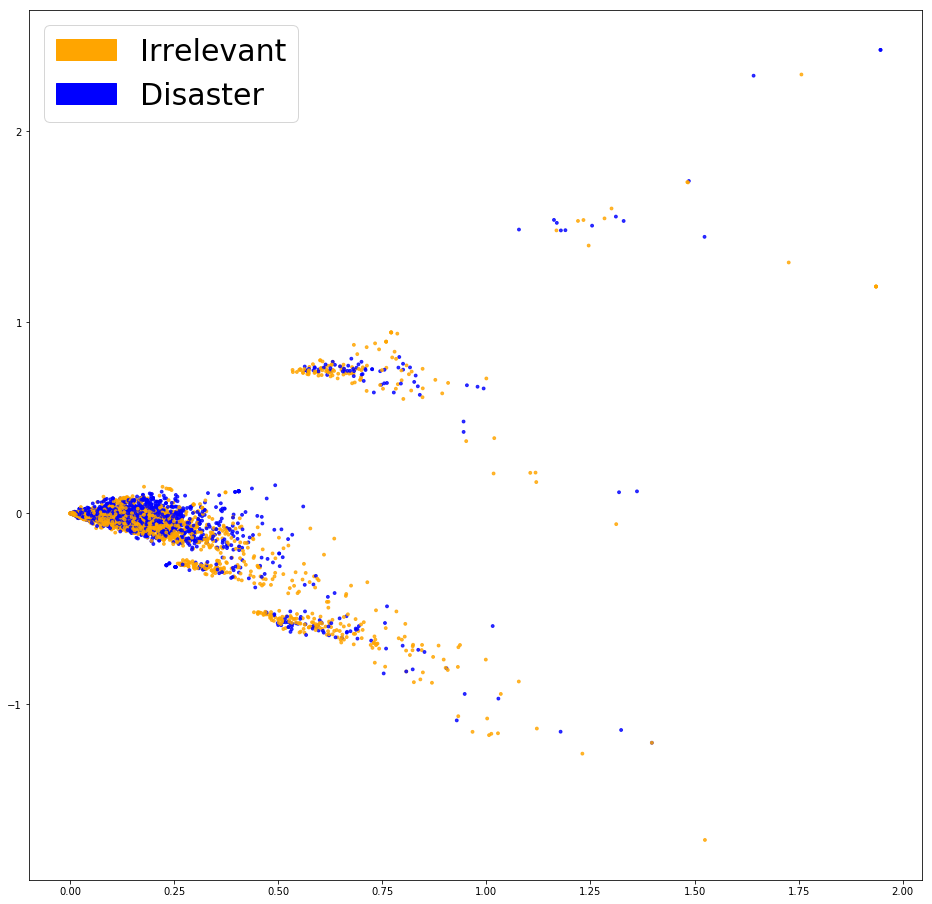

In [21]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_target, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_target))}
        color_column = [color_mapper[label] for label in test_target]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_target, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated.

### Fitting a Logistic Regression

**Get the best parameters using GridSearchCV**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [23]:
#parameter grid

parameters={"C":[0.001, 0.01, 0.1, 1, 10, 30, 100, 1000], "penalty":["l2"], 'solver': ['newton-cg'], 'fit_intercept':[True,False], 'class_weight':['balanced'], 'random_state':[101], 'multi_class':['multinomial'] }

In [24]:
grid = GridSearchCV(LogisticRegression(), parameters, verbose=3, cv=10, n_jobs=-1)

In [25]:
grid.fit(X_train_counts, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   14.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 30, 100, 1000], 'penalty': ['l2'], 'solver': ['newton-cg'], 'fit_intercept': [True, False], 'class_weight': ['balanced'], 'random_state': [101], 'multi_class': ['multinomial']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [26]:
# View The Best Parameters
print('Best C:', grid.best_estimator_.get_params()['C'])
print('Best fit_intercept:', grid.best_estimator_.get_params()['fit_intercept'])
print("accuracy :",grid.best_score_)

Best C: 0.1
Best fit_intercept: True
accuracy : 0.8016513417151435


In [27]:
y_predicted_counts = grid.predict(X_test_counts)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.804, precision = 0.803, recall = 0.804, f1 = 0.803


In [30]:
print(classification_report(y_test,y_predicted_counts)) 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1330
           1       0.78      0.73      0.76       954

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.80      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284



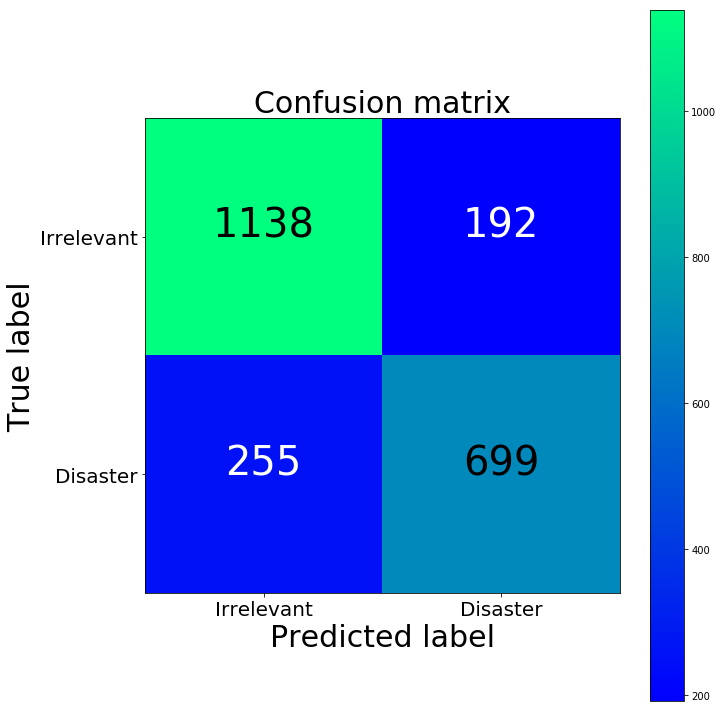

[[1138  192]
 [ 255  699]]


In [31]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

The false positive is pretty high and it could be a high cost to law enforcement for example.

### Further inspection into the classifier

In [32]:
clf = LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', fit_intercept= True, multi_class='multinomial', n_jobs=-1, random_state=101)
clf.fit(X_train_counts, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=101, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [33]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

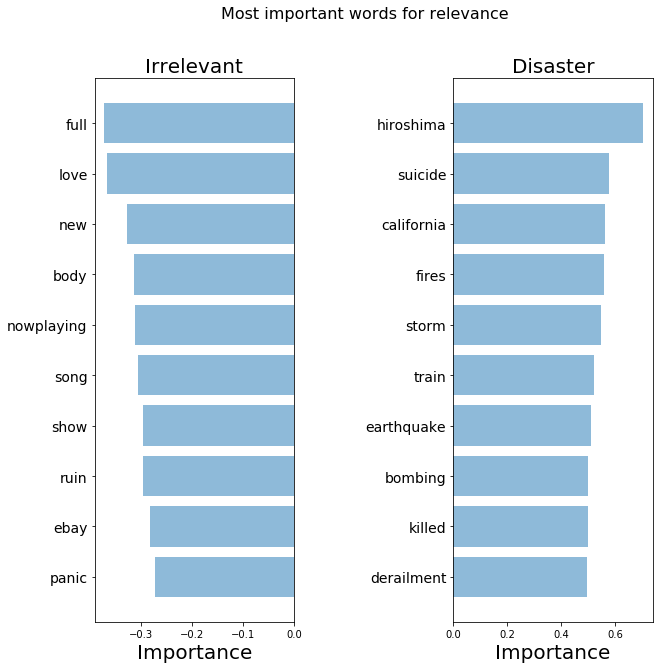

In [34]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The classifier currectly picks up on patterns, but also clearly seems to be overfitting on some irrelevant terms such as California

### TFIDF Bag of Words 

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

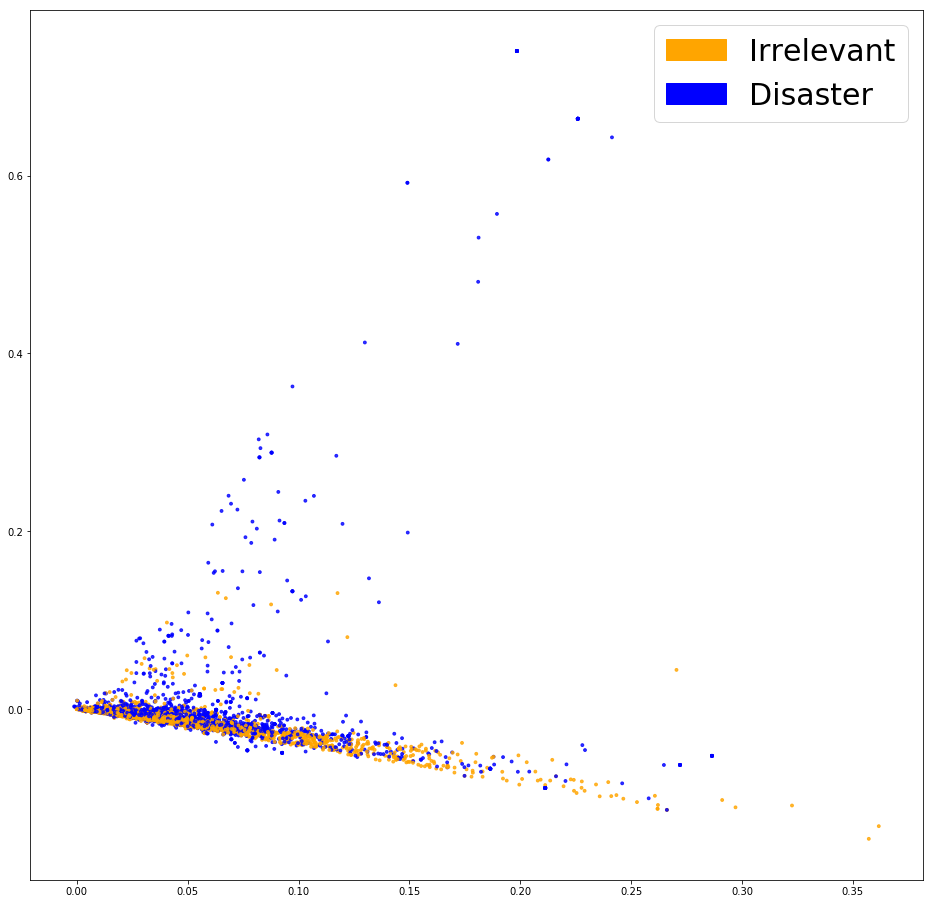

In [36]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

The embeding is closer together than previous

In [37]:
clf_tfidf = LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', fit_intercept= True, multi_class='multinomial', n_jobs=-1, random_state=101)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [38]:

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.802, precision = 0.801, recall = 0.802, f1 = 0.801


In [39]:
print(classification_report(y_test,y_predicted_tfidf))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1330
           1       0.78      0.73      0.75       954

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



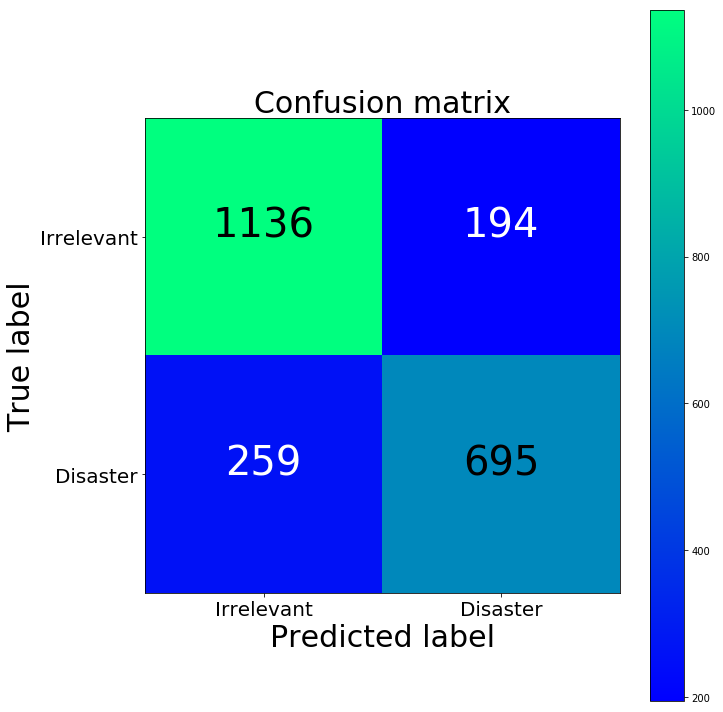

TFIDF confusion matrix
[[1136  194]
 [ 259  695]]
BoW confusion matrix
[[1138  192]
 [ 255  699]]


In [40]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

This model has increased our false positive

In [41]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

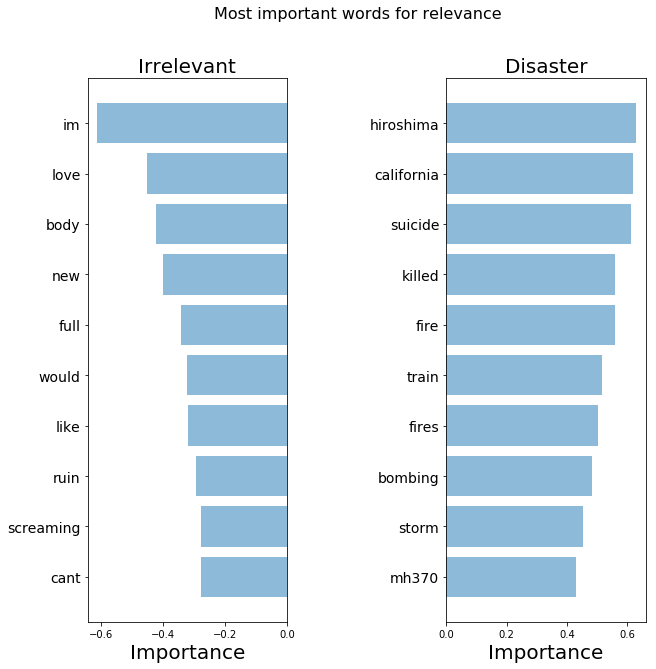

In [42]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

As we can see the model clearly seems to be overfitting on some irrelevant terms

### Capturing semantic meaning

In [43]:
import gensim

word2vec_path = "/Users/Cho/Desktop/Python/Refactored_Py_DS_ML_Bootcamp-master/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [46]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, train_set, generate_missing=False):
    embeddings = train_set['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

In [47]:
embeddings = get_word2vec_embeddings(word2vec, train_set)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_targets,test_size=0.2, random_state=40)

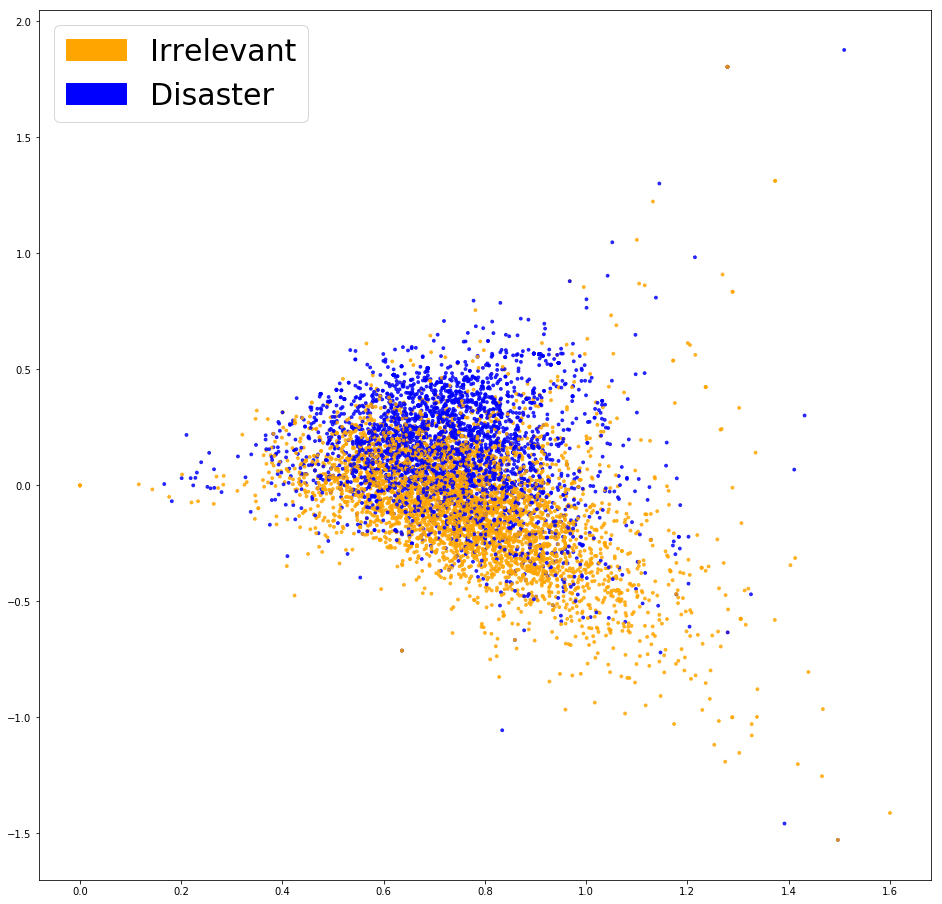

In [48]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_targets)
plt.show()

In [49]:
clf_w2v = LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', fit_intercept= True, multi_class='multinomial', n_jobs=-1, random_state=101)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [50]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.790, precision = 0.790, recall = 0.790, f1 = 0.790


In [51]:
print(classification_report(y_test_word2vec,y_predicted_word2vec))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       852
           1       0.76      0.77      0.76       671

   micro avg       0.79      0.79      0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



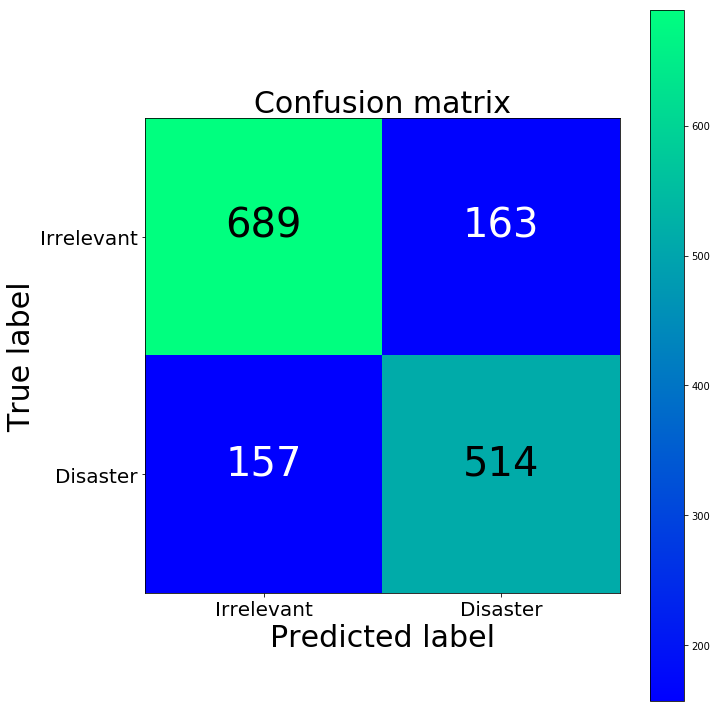

Word2Vec confusion matrix
[[689 163]
 [157 514]]
TFIDF confusion matrix
[[1136  194]
 [ 259  695]]
BoW confusion matrix
[[1138  192]
 [ 255  699]]


In [52]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

**Predicting with test set**

In [53]:
predictions = grid.predict(test_set_count)

In [54]:
predictions[:100]

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
test_set.head(10)['text']

0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4               typhoon soudelor kills 28 china taiwan
5                                   shaking earthquake
6    theyd probably still show life arsenal yesterd...
7                                                  hey
8                                             nice hat
9                                                 fuck
Name: text, dtype: object

**Submission**

In [56]:
sample_submission = pd.read_csv("sample_submission.csv")

In [57]:
sample_submission["target"] = predictions

In [58]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [59]:
sample_submission.to_csv("submission.csv", index=False)